# Experiment and path specification

In [63]:
# Specify the experiment for analysis
experiment='cxilu9218'
runNumber = 18

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [64]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
print os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic'
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic
igabalsk



# Leveraging the batch queue to quickly grab detector data

## Loading libraries

In [65]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsLibraries')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

## Load point data

In [66]:
pointData = load_obj( os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )

/cds/data/psdm/cxi/cxilu9218/results/igabalsk/pointData-run-18 remembered!


## Plot histogram of result

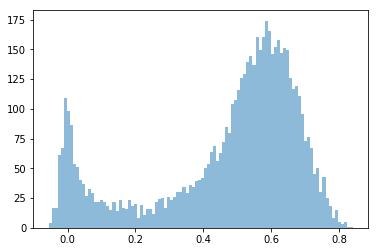

In [67]:
detArrays = pointData

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['xrayEnergy'], bins=100,normed=False, alpha=0.5);

# Read in CSPAD via batch job

## Specify good idxs

In [68]:
goodIdx = runFilter( pointData , filterOn=['xrayEnergy', 'ttfltpos'], maddevs=3 ).astype(bool)
print 'Number of good shots: ', len(goodIdx[goodIdx==True])

Number of good shots:  3523


## Now generate time delays

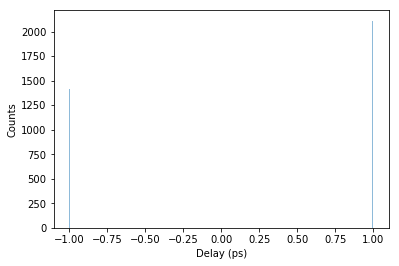

In [69]:
# Calibrated timetool for LU92
TTPoly = np.array([2.95684259e-06, -1.43969413e-03]) 

TTFltPos = pointData['ttfltpos']
TTCorrFltPos = TTPoly[1]*TTFltPos+TTPoly[0]
TTTime = 0*TTCorrFltPos - 1e9/3e8*2*(pointData['stageencoder']-56.35)

# NOTE: This is a placeholder, and should be removed on runs with timetool data
# TTTime = np.zeros(pointData['xrayEnergy'].shape)

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(TTTime[goodIdx], bins=200,normed=False, alpha=0.5)
ax2.set_xlabel('Delay (ps)')
ax2.set_ylabel('Counts')
plt.show()

# Read in all images
## If you just want to look at all the images at once

In [70]:
# tagList = []
# size_slice = len(goodIdx[goodIdx==True])
# for idx in range(1):
#     filteredSeconds = pointData['seconds'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     filteredNanoseconds = pointData['nanoseconds'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     filteredFiducials = pointData['fiducials'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# # batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
# batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
# timebins=np.arange(10)
# batchThreads.Queue = 'psfehhiprioq'   
# batchThreads.start()

In [71]:
print np.unique(TTTime)
print np.unique(pointData['stageencoder'])

[-1.  1.]
[56.2 56.5]


# Read in timebinned CSPAD
## If you want to timebin your images

In [72]:
# timebins = np.arange( -1.5,1.5,.03 )
# timebins are in picoseconds
# timebins = np.arange( 2.,5.5,.03 ) 
# timebins = np.arange( -1, 1, .1 )
# timebins = np.array([-1.25,0.75])
timebins = np.unique(TTTime)
print 'Number of timebins: ', len(timebins)
# dt = timebins[1]-timebins[0]
dt = 0.05
NT = timebins.size

tagList = []
for idx, t in enumerate(timebins):
    tIndex = (TTTime >= t-dt/2.)&(TTTime < t+dt/2.)
    allIndex = tIndex & goodIdx
    filteredSeconds = pointData['seconds'][allIndex]
    filteredNanoseconds = pointData['nanoseconds'][allIndex]
    filteredFiducials = pointData['fiducials'][allIndex]
    tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')

batchThreads.Queue = 'psanaq'
batchThreads.RunType = 'mpirun python2'
batchThreads.start()


Number of timebins:  2
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-18-temp-CSPAD-0.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-18-temp-CSPAD-0.py; exit'
Output: Job <402209> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-18-temp-CSPAD-1.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-18-temp-CSPAD-1.py; exit'

## Check job status

In [73]:
print batchThreads.status
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata

Running
JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
402209  igabals RUN   psanaq     psanagpu104 psana1304   *SPAD-0.py Nov 27 20:43
402215  igabals RUN   psanaq     psanagpu104 psana1109   *SPAD-1.py Nov 27 20:43


IOError: Did you load the correct file? /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-0-run-18
[Errno 2] No such file or directory: '/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-0-run-18.pkl'
IOError: Did you load the correct file? /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-1-run-18
[Errno 2] No such file or directory: '/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-1-run-18.pkl'


## Kill threads if they die

In [28]:
batchThreads.requestStop()
time.sleep(5)
stdoutdata, stderrdata = bkill(killAll=True)
print stdoutdata
print stderrdata

Job <391578> is being terminated
Job <391589> is being terminated

Job <391600>: Job has already finished



# Save resulting CSPAD

In [52]:
batchThreads.gather()
CSPAD = batchThreads.CSPAD
variance = batchThreads.variance
counts = batchThreads.counts

/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-0-run-17 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-1-run-17 remembered!


In [53]:
from scipy.io import savemat
np.save(os.environ['RESULTSPATH']+'/timebins-run-%d' % runNumber ,timebins)
np.save(os.environ['RESULTSPATH']+'/CSPAD-run-%d' % runNumber  , CSPAD)
np.save(os.environ['RESULTSPATH']+'/variance-run-%d' %  runNumber , variance)
np.save(os.environ['RESULTSPATH']+'/counts-run-%d' % runNumber  , counts)

filename = os.environ['RESULTSPATH']+'/timebinned-detector-images-run-%d' % runNumber
mdict = {'timebins':timebins,'CSPAD':CSPAD,'variance':variance,'counts':counts}
savemat(filename, mdict)

# Plot CSPAD

In [54]:
# # Optional code if timebinned frames are already saved
timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)

In [55]:
for i in range(CSPAD.shape[-1]):
    m = np.mean(CSPAD[:,:,:,i])
    if not np.isnan(m):
        print i, np.mean(CSPAD[:,:,:,i]), counts[i][0], timebins[i]

0 0.07491664750009358 1927.0 -0.9999999999999906
1 0.07642797675708198 2159.0 0.9999999999999906


(0.0, 5.5)


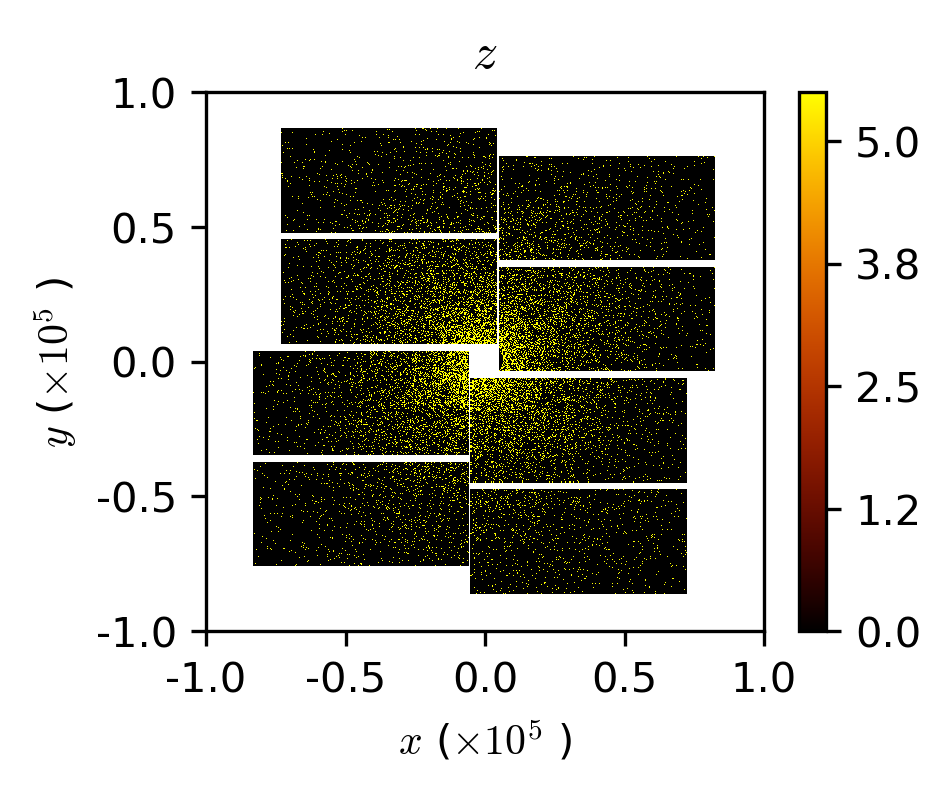

In [58]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False, NTILE=8 ):
    figOpts = {'xLims':[-1e5,1e5],'yLims':[-1e5,1e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(NTILE):
    
        if cspadMask is not None:
            cspadTile = cspad[iTile,:,:]
            tileMask = ~cspadMask[iTile,:,:]
            cspadTile[tileMask] = 0
        
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
            
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspadTile , newFigure=newFigure, **figOpts);


x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)
# cspadMask = createMask(experiment=experiment, run=runNumber, detType='Jungfrau').astype(bool)
cspadMask = np.ones_like(x).astype(bool)
print(cspadMask.shape)

print CSPAD.shape
CSPADbinned = CSPAD

# CSPADbinned[CSPADbinned>10]=0
CSPAD2plot = np.nansum(CSPADbinned[:,:,:,:],axis=-1)#-CSPADbinned[:,:,:,53]
plotCSPAD( 100*CSPAD2plot, x , y , zLims=[0,5],
          cspadMask=cspadMask, divergent=False, NTILE=8 )
# plt.savefig('background_thresholded_summed_image.png')

In [57]:
print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format('Index','Count','Sum','Median','Variance')
for i in range(CSPAD.shape[-1]):
    if counts[i][0]>0:
        vals = (i, counts[i][0], round(np.sum(CSPAD[:,:,:,i])),round(np.median(CSPAD[:,:,:,i]),4), round(np.var(CSPAD[:,:,:,i]),4))
        print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format(*vals)

Index Count      Sum   Median Variance
0     1927.0 314223.0      0.0 1080.7431
1     2159.0 320562.0      0.0 1080.9331
